In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                                  weights='imagenet',
                                                  input_shape=(224,224,3))



16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable=False
base_model.summary()

In [ ]:
# sigmoid 0~1 , prediction >0.8 = >1, prediction < 0.3  =>0 ,
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation = 'relu')(x)
output_layer = Dense(1, activation = 'sigmoid')(x)
our_efficient_model = Model(inputs = base_model.input, outputs = output_layer)
our_efficient_model.summary()

In [ ]:
# classification train(2/15)

In [ ]:
path_img = '/content/wandg.jpg'
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()  ## selective search initialize
image = cv2.imread(path_img)
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

In [ ]:
len(ssresults)

959

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
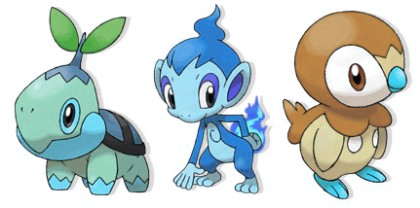

In [ ]:
image

In [ ]:
for box in ssresults:
  print(box)
  x,y,w,h = box
  cv2.rectangle(image, (x,y), (x + w, y+h), (255,0,0), 1)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)

In [ ]:
# fine tuning 진행
our_efficient_model.compile('adam', 'binary_crossentropy',metrics=['accuracy'])

In [ ]:
!rm -rf dataset
!mkdir dataset
!unzip /content/drive/MyDrive/pokedata -d dataset

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255 , validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    'dataset/',
    target_size =(224,224),
    batch_size=32,
    class_mode='binary',
    subset = 'training'
)
validation_generator = train_datagen.flow_from_directory(
    'dataset/',
    target_size =(224,224),
    batch_size=32,
    class_mode='binary',
    subset = 'validation'
)

Found 247 images belonging to 2 classes.
Found 61 images belonging to 2 classes.


In [ ]:
our_efficient_model.fit(train_generator,validation_data=validation_generator,epochs=10)

In [ ]:
len(our_efficient_model.layers)
#our_efficient_model.summary()

241

In [ ]:
for layer in our_efficient_model.layers[:220]:
    layer.trainable = False
for layer in our_efficient_model.layers[220:]:
    layer.trainable = True

In [ ]:
our_efficient_model.summary()

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
our_efficient_model.compile(opt, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_path = '/content/drive/MyDrive/finetuning_detection'
mc = tf.keras.callbacks.ModelCheckpoint(checkpoint_path ,
                                        monitor='val_loss',
                                        save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

our_efficient_model.fit(train_generator,
                        validation_data=validation_generator,
                        epochs=100,
                        callbacks = [mc,es])

In [ ]:
## detection 진행
image = cv2.imread(path_img)
cropped_image = []
# ss 제안 받은 영역 crop
for box in ssresults:
  x, y, w, h = box
  crop = image[y:y+h, x:x+w]
  cropped_image.append(crop)

# crop 한 영역을 전처리
preprocessed_image = []
for img in cropped_image:
  resized_image = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
  normalized_image = resized_image / 255.0
  preprocessed_image.append(normalized_image)

import numpy as np
preprocessed_image = np.array(preprocessed_image)


In [ ]:
scores = our_efficient_model.predict(preprocessed_image)
# 1. 0.5 이상 이면 1, 0.5미만이면 0클래스로
# 2. 각각 클래스에 대한 좌표값과 예측결과 값을 같이
# 3. 0번 클래스는 [preprocessed_image[0] 좌표 값(x,y,w,h) , 1 - 0.2]
# 4. 1번 클래스는 [preprocessed_image[1] 좌표 값(x,y,w,h), 0.99]

30/30 [==============================] - 3s 107ms/step


In [ ]:
one_class = []
zero_class = []
threshold = 0.5
for idx, score in enumerate(scores):
  if score[0] > 0.5:
    x, y, w, h=ssresults[idx]
    if score[0] > threshold:
      one_class.append([x,y,w,h,score[0]])
  else:
    x,y,w,h=ssresults[idx]
    if 1-score[0] > threshold:
      zero_class.append([x,y,w,h,1-score[0]])
one_class, zero_class

In [ ]:
bbox = []
scores_list = []
for box in one_class:
    x,y,w,h = box[:-1]
    bbox.append([x,y,x+w,y+h])
    scores_list.append(box[-1])

nms_idices_one = cv2.dnn.NMSBoxes(bbox, scores_list ,
                       score_threshold=0.7, nms_threshold=0.5)

nms_boxes_one = [bbox[i] for i in nms_idices_one]
nms_scores_one = [scores_list[i] for i in nms_idices_one]


bbox = []
scores_list = []
for box in zero_class:
    x,y,w,h = box[:-1]
    bbox.append([x,y,x+w,y+h])
    scores_list.append(box[-1])

nms_idices_zero = cv2.dnn.NMSBoxes(bbox, scores_list ,
                       score_threshold=0.7, nms_threshold=0.5)

nms_boxes_zero = [bbox[i] for i in nms_idices_zero]
nms_scores_zero = [scores_list[i] for i in nms_idices_zero]

#nms threshold = BBOX간 겹침의 허용 정도 (0.3~0.5)
#score threshold = BBOX의 prediction 허용 정도(이 수치값을 넘어야 객체로 인정)

In [ ]:
nms_boxes_zero

[]

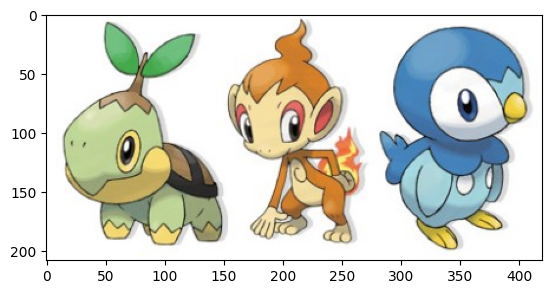

In [ ]:
for box in nms_boxes_one:
    xmin,ymin,xmax,ymax = box
    cv2.rectangle(image, (xmin,ymin), (xmax, ymax), (255,0,0), 1)

for box in nms_boxes_zero:
    xmin,ymin,xmax,ymax = box
    cv2.rectangle(image, (xmin,ymin), (xmax, ymax), (0,0,255), 1)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
# 1번 클래스(파란색)만 출력을 하고 있음, 0번 클래스(빨간색)도 그려서 출력하는 코드를 위에서 추가
# 리팩토링은 고려 X